### Введение

Прежде чем реализовать какой либо критерий остановки обучения - необходимо понять, когда и почему обучение нужно останавливать.

Бывают разные ситуации.

В данном ноутбуке разобраны две ситуации:
- остановка при переобучении;
- выход модели на "плато" обучения (нет значимых улучшений в течении n эпох).

Хоть это и разные случаи, но и в первом и во втором, модель с какой то эпохи перестает улучшаться.

### Импорты

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('dark_background')

### Создание данных для задачи классификации

Т.к. ушел с гугл колаб на локальную машину, понадобилось создать локальную версию данных, заодно попрактиковался

In [2]:
import struct
import sys

from array import array
from os import path

In [4]:
train_dataset = torchvision.datasets.MNIST(root='sample_data/', train=True, download=True)
test_dataset =torchvision.datasets.MNIST(root='sample_data/', train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|███████████████████████████████████████| 9.91M/9.91M [00:19<00:00, 506kB/s]

Extracting sample_data/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -3] Temporary failure in name resolution>




00%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 371kB/s]

Extracting sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.46MB/s]

Extracting sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.11MB/s]

Extracting sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST/raw



In [5]:
def read(dataset):
    if dataset == 'training':
        path_img = 'sample_data/MNIST/raw/train-images-idx3-ubyte'
        path_lbl = 'sample_data/MNIST/raw/train-labels-idx1-ubyte'

    elif dataset == 'testing':
        path_img = 'sample_data/MNIST/raw/t10k-images-idx3-ubyte'
        path_lbl = 'sample_data/MNIST/raw/t10k-labels-idx1-ubyte'

    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    with open(path_lbl, 'rb') as f_lable:
        _, size = struct.unpack('>II', f_lable.read(8))
        lbl = array('b', f_lable.read())

    with open(path_img, 'rb') as f_img:
        _, size, rows, cols = struct.unpack('>IIII', f_img.read(16))
        img = array('B', f_img.read())

    return lbl, img, size, rows, cols

In [6]:
def write_dataset(labels, data, size, rows, cols, output_dir):

    classes = {i: f'class_{i}' for i in range(10)}

    output_dirs = [
        path.join(output_dir, classes[i])
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in enumerate(labels):
        output_filename = path.join(output_dirs[label], str(i) + '.jpg')
        print('writing ' + output_filename)

        with open(output_filename, 'wb') as h:
            data_i = [
                data[(i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols)]
                for j in range(rows)
            ]
            data_array = np.asarray(data_i)

            im = Image.fromarray(data_array)
            im.save(output_filename)

In [7]:
output_path = 'mnist'

In [ ]:
for dataset in ['training', 'testing']:
    write_dataset(*read(dataset), path.join(output_path, dataset))

### Способ 1: "Остановка при переобучении"

Способ №1 будет разобран на примере задачи классификации датасета MNIST.

В данном разделе рассматривается ситуация остановки при переобучении.

In [134]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [117]:
# device = 'cpu'
# device

'cpu'

#### Создание Dataset

In [57]:
# данный код из урока, но он подходит только для 'cpu'
# в ячейке ниже модернизированная версия, чтобы можно было обучать модель на 'cuda'
# class MNISTDataset(Dataset):
#     def __init__(self, path, transform=None):
#         self.path = path
#         self.transform = transform

#         self.len_dataset = 0 # длина датасет
#         self.data_list = [] # список кортежей путей до файла и позиции в onehot векторе

#         # итерируемся по папке с основными файлами
#         for path_dir, dir_list, file_list in os.walk(path):
#             if path_dir == path:
#                 self.classes = sorted(dir_list)
#                 self.class_to_idx = {
#                     cls_name: i for i, cls_name in enumerate(self.classes)
#                     }
#                 continue

#             cls = path_dir.split('/')[-1]

#             for name_file in file_list:
#                 file_path = os.path.join(path_dir, name_file)
#                 self.data_list.append((file_path, self.class_to_idx[cls]))

#             self.len_dataset += len(file_list)

#     def __len__(self):
#         return self.len_dataset

#     def __getitem__(self, index):
#         file_path, target = self.data_list[index]
#         sample = Image.open(file_path)

#         if self.transform is not None:
#             sample = self.transform(sample)

#         return sample, target

В ячейке выше код для загрузки датасет для задачи классификации из предыдущих ноутбуков.

Автор курса в рамках видео рассматривает решение задачи на cpu. Я же решил собрать датасет, чтобы можно было решать и на cpu и на gpu.

В ячейке ниже класс для формирования датасета немного изменен.

Его можно использовать для решения задачи классификации в том числе и на графическом процессоре.

In [118]:
### Пробуем для 'cuda'
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0 # длина датасет
        self.data_list = [] # список кортежей путей до файла и позиции в onehot векторе

        # итерируемся по папке с основными файлами
        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = sorted(dir_list)
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                    }
                continue

            cls = path_dir.split('/')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = Image.open(file_path)

        if self.transform is not None:
            sample = self.transform(sample)
            target = self.transform(target)

        return sample, target

In [119]:
# Преобразование для изображений
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [120]:
# создание датасетов
train_data = MNISTDataset('mnist/training', transform=transform)
test_data = MNISTDataset('mnist/testing', transform=transform)

In [121]:
train_data, val_data = random_split(train_data, [0.7, 0.3])

In [122]:
# Создание загрузчиков
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Создание модели

In [111]:
class MyModel(nn.Module):
    def __init__(self,input,output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [123]:
model = MyModel(784, 10).to(device)

In [124]:
# Проверяем правильность построения модели
input = torch.rand([16, 784], dtype=torch.float32).to(device)

out = model(input)
out.shape    # (16,10)

torch.Size([16, 10])

In [125]:
# выбираем функцию потерь и оптимизатор градиентного спуска
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

#### Тренировка модели

In [126]:
EPOCHS = 50
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None
threshold = 0.5
count = 0

В цикл обучения была добавлена проверка.

Она достаточно простая. Мы создаем переменную счетчика.

Если счетчик больше или равен 5 эпохам, то мы прекращаем обучение.

Важно понимать, что мы так же добавили условие в часть кода с сохранением модели.

Если модель сохраняется, то счетчик обнуляется.

Таким образом мы соблюдаем условие получения и сохранения значимых изменений модели.

In [127]:
# Цикл обучения
for epoch in range(EPOCHS):

    # Тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # Данные
        # (batch.size, 1, 28, 28) --> (batch.size, 784)
        x = x.reshape(-1, 28*28).to(device)
        # (batch.size, int) --> (batch.size, 10), dtype=float32
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)

        # Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        # Обратный проход
        opt.zero_grad()
        loss.backward()
        
        # Шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")


    # Расчет значения метрики
    running_train_acc = true_answer / len(train_data)

    # Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # Проверка модели (Валидация)
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # Данные
            # (batch.size, 1, 28, 28) --> (batch.size, 784)
            x = x.reshape(-1, 28*28).to(device)
            # (batch.size, int) --> (batch.size, 10), dtype=float32
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)

            # Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

        # Расчет значения метрики
        running_val_acc = true_answer / len(val_data)

        # Сохранение значения функции потерь и метрики
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler._last_lr[0]
        lr_list.append(lr)

        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}")

        # добавляем две проверки, для сохранения лучшей модели
        if best_loss is None:
            best_loss = mean_val_loss
      
        if mean_val_loss < best_loss - best_loss*threshold:
            best_loss = mean_val_loss
            
            # если модель улучшила свои показатели, то отсчет эпох пойдет заново
            # обнуляем счетчик
            count = 0
            
            # так же сохраняем словарь в случае улучшения модели
            checkpoint = {
                'state_model': model.state_dict(),
                'state_opt': opt.state_dict(),
                'state_lr_scheduler': lr_scheduler.state_dict(),
                'loss':{
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'best_loss': best_loss
                },
                'metric':{
                    'train_acc': train_acc,
                    'val_acc': val_acc
                },
                'lr': lr_list,
                'epoch':{
                    'EPOCHS': EPOCHS,
                    'save_epoch': epoch
                },
                'threshold': threshold
            }
    
            
    
            torch.save(checkpoint, f'model_state_dict_epoch_{epoch+1}.pt')
            print(f"На эпохе: {epoch+1}, сохранена модель со значением функции потерь на валидаци: {mean_val_loss:.4f}", end='\n\n')

        # условие, для остановки обучения по достижению счетчиком определенного значения!
        if count >= 5:
            print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
            break
            
        # в конце каждой эпохи увеличиваем счетчик на 1
        count += 1

Epoch [1/50], train_loss=0.4304, train_acc=0.8745, val_loss=0.3077, val_acc=0.9075


Epoch [2/50], train_loss=0.2419, train_acc=0.9282, val_loss=0.2094, val_acc=0.9393


Epoch [3/50], train_loss=0.1772, train_acc=0.9477, val_loss=0.1740, val_acc=0.9483


Epoch [4/50], train_loss=0.1420, train_acc=0.9569, val_loss=0.1813, val_acc=0.9461


Epoch [5/50], train_loss=0.1178, train_acc=0.9653, val_loss=0.1339, val_acc=0.9603
На эпохе: 5, сохранена модель со значением функции потерь на валидаци: 0.1339



Epoch [6/50], train_loss=0.1007, train_acc=0.9705, val_loss=0.1521, val_acc=0.9547


Epoch [7/50], train_loss=0.0895, train_acc=0.9720, val_loss=0.1163, val_acc=0.9653


Epoch [8/50], train_loss=0.0773, train_acc=0.9764, val_loss=0.1254, val_acc=0.9635


Epoch [9/50], train_loss=0.0699, train_acc=0.9784, val_loss=0.1164, val_acc=0.9653


Epoch [10/50], train_loss=0.0627, train_acc=0.9805, val_loss=0.1294, val_acc=0.9616
Обучение остановлено на 10 эпохе.


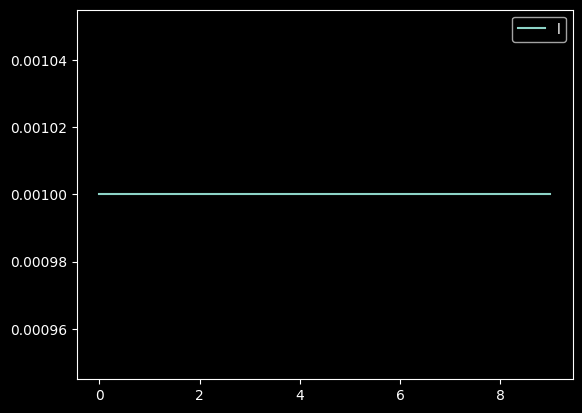

In [128]:
plt.plot(lr_list)
plt.legend('lr_list')
plt.show()

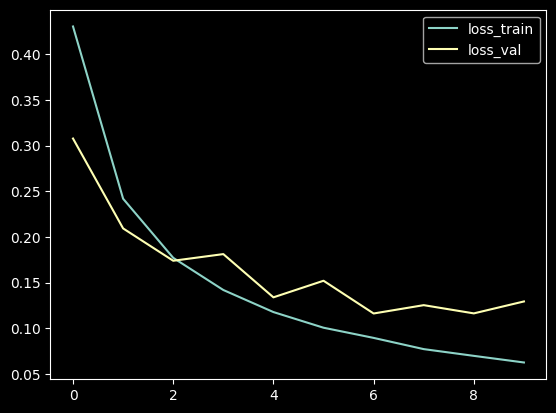

In [129]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

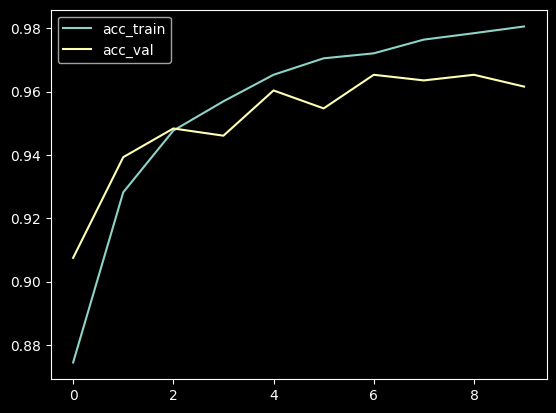

In [130]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

#### Проверка обученной модели

Для тестирования корректности предсказательной способности модели, необходимо проверить ее на данных, которые она не видела ранее.

Тестировать модель мы будем на тестовой выборке, которую создавали ранее.

Цикл тестирования модели по сути аналогичен циклу валиадации. Единственное вилидационный датасет заменяется на тестовый.

ВАЖНО ПОМНИТЬ!

ОДНУ модель тестировать на этих данных можно только ОДИН раз.

In [131]:
# создаю новую модель, в которую подгружу сохраненные данные, ранее обученной модели
new_model = MyModel(784, 10).to(device)

In [132]:
# подгружаю состояние сохраненной модели
checkpoint = torch.load('model_state_dict_epoch_5.pt')
new_model.load_state_dict(checkpoint['state_model'])

/tmp/ipykernel_6708/2785751043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_state_dict_epoch_5.pt')


<All keys matched successfully>

In [133]:
model.eval()
with torch.no_grad():
    running_test_loss = []
    true_answer = 0
    for x, targets in test_loader:
        # Данные
        # (batch.size, 1, 28, 28) --> (batch.size, 784)
        x = x.reshape(-1, 28*28).to(device)
        # (batch.size, int) --> (batch.size, 10), dtype=float32
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)

        # Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        running_test_loss.append(loss.item())
        mean_test_loss = sum(running_test_loss)/len(running_test_loss)

        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

    # Расчет значения метрики
    running_test_acc = true_answer / len(test_data)


    print(f"test_loss={mean_test_loss:.4f}, test_acc={running_test_acc:.4f}", end='\n\n')

test_loss=0.1195, test_acc=0.9638



Как мы можем наблюдать, модель неплохо справляется на данных, которые ранее не видела

### Способ 2: "Создание пользовательского класса EarlyStopping"

Способ 2 будет разобран на примере задачи Регрессии.

В данном разделе рассматривается ситуация выхода модели на "плато" (нет значимых улучшений в течении n эпох).

#### Релизация класса EarlyStopping

Реализация данного класса позволяет сделать остановку обучения более автономным и функциональным.

С классом, конечно надо будет посидеть и повнимательнее разобраться со взаимодействим методов __call__ и __changed_better__

In [168]:
class EarlyStopping:
    def __init__(self, mode='min', patience=10, threshold=0.0001, threshold_mode='rel'):
        # проверка на правильность переданных параметров
        if mode not in {'min', 'max'}:
            raise ValueError(f'Параметр mode может принимать только значения max и min.')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError(f'Параметр threshold_mode может принимать только значения rel и abs.')
        if not isinstance(patience, int):
            raise TypeError(f'Параметр patience должен быть целым число.')
        if not isinstance(threshold, float):
            raise TypeError(f'Параметр threshold должен быть float и меньше 1.0.')
        if threshold >= 1.0:
            raise VelueError(f'Параметр threshold должен быть меньше 1.0.')

        self.mode = mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count = 0
        self.best = None

    # в метод __call__ передаем отслеживаемый параметр
    # это либо функция потерь, либо значение метрики (на данном этапе)
    def __call__(self, tracked_parameter):
        current = float(tracked_parameter)
        if self.best is None:
            self.best = current
            return False

        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
        else:
            self.count += 1

        if self.count >= self.patience:
            self.count = 0
            return True
        return False

    # работу передаваемых в метод параметров мы разбирали в ноутбуке с шедулерами
    def changed_better(self, current, best):
        if self.mode == 'min' and self.threshold_mode == 'rel':
            return current < best - best * self.threshold

        elif self.mode == 'min' and self.threshold_mode == 'abs':
            return current < best - self.threshold

        elif self.mode == 'max' and self.threshold_mode == 'rel':
            return current > best + best * self.threshold

        else:    # mode == 'max' and threshold == 'abs':
            return current > best + self.threshold

#### Задача регрессии

In [136]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [137]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = Image.open(path_img)
        coord = self.dict_coords[name_file]

        if self.transform:
            img = self.transform(img)
            coord = torch.tensor(coord, dtype=torch.float32)


        return img, coord

In [138]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [139]:
dataset = DatasetReg(path='dataset', transform=transform)

Coord = tensor([28., 31.])


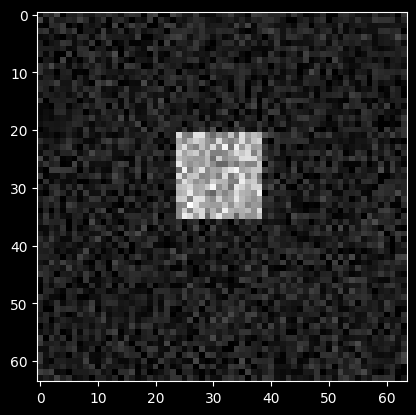

In [140]:
img, coord = dataset[2512]

print(f'Coord = {coord}')
plt.imshow(img.numpy()[0], cmap='gray')

In [141]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])

In [142]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [143]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [177]:
# создаем и отправляем на cuda
model = MyModel(64*64, 2).to(device)

In [178]:
# Проверяем правильность построения модели
input = torch.rand([16, 64*64], dtype=torch.float32).to(device)

out = model(input)
out.shape    # (16,2)

torch.Size([16, 2])

In [179]:
# выбираем функцию потерь и оптимизатор градиентного спуска
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)
earlystopping = EarlyStopping(mode='min', patience=10)

In [180]:
EPOCHS = 100
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None

In [181]:
# Цикл обучения
for epoch in range(EPOCHS):

    # 1. Тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # - Данные
        # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # - Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        # - Обратный проход
        opt.zero_grad()
        loss.backward()
        # - Шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")


    # 2. Расчет значения метрики
    running_train_acc = true_answer / len(train_set)

    # 3. Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # 4. Проверка модели (Валидация)
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # - Данные
            # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device)

            # - Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        # 2. Расчет значения метрики
        running_val_acc = true_answer / len(val_set)

        # 3. Сохранение значения функции потерь и метрики    true_answer = 0

        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")

    # добавляем две проверки, для сохранения лучшей модели
    if best_loss is None:
        best_loss = mean_val_loss
    # это самое простое условие, но это неприемлемо
    # if mean_val_loss < best_loss:
    #     best_loss = mean_val_loss
    # мы будем сохранять модель, чей лосс улучшился на ЗНАЧИМОЕ для нас значение
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss

        checkpoint = {
            'state_model': model.state_dict(),
            'state_opt': opt.state_dict(),
            'state_lr_scheduler': lr_scheduler.state_dict(),
            'loss':{
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss
            },
            'metric':{
                'train_acc': train_acc,
                'val_acc': val_acc
            },
            'lr': lr_list,
            'epoch':{
                'EPOCHS': EPOCHS,
                'save_epoch': epoch
            }
        }
        

        torch.save(checkpoint, f'model_reg_state_dict_epoch_{epoch+1}.pt')
        print(f"На эпохе: {epoch+1}, сохранена модель со значением функции потерь на валидаци: {mean_val_loss:.4f}", end='\n\n')

    # здесь дописать комментарий
    if earlystopping(mean_val_loss):
        print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
        break

Epoch [1/100], train_loss=1.7746, train_acc=0.6183, val_loss=0.2143, val_acc=0.4341, lr=0.0010


Epoch [2/100], train_loss=0.1403, train_acc=0.6789, val_loss=0.1633, val_acc=0.5838, lr=0.0010
На эпохе: 2, сохранена модель со значением функции потерь на валидаци: 0.1633



Epoch [3/100], train_loss=0.1211, train_acc=0.7327, val_loss=0.1123, val_acc=0.7274, lr=0.0010
На эпохе: 3, сохранена модель со значением функции потерь на валидаци: 0.1123



Epoch [4/100], train_loss=0.1015, train_acc=0.7947, val_loss=0.0589, val_acc=0.9278, lr=0.0010
На эпохе: 4, сохранена модель со значением функции потерь на валидаци: 0.0589



Epoch [5/100], train_loss=0.0916, train_acc=0.8221, val_loss=0.0714, val_acc=0.8842, lr=0.0010


Epoch [6/100], train_loss=0.0807, train_acc=0.8567, val_loss=0.0955, val_acc=0.8118, lr=0.0010


Epoch [7/100], train_loss=0.0714, train_acc=0.8852, val_loss=0.0629, val_acc=0.9161, lr=0.0010


Epoch [8/100], train_loss=0.0674, train_acc=0.8978, val_loss=0.0631, val_acc=0.9078, lr=0.0010


Epoch [9/100], train_loss=0.0651, train_acc=0.9049, val_loss=0.0705, val_acc=0.9032, lr=0.0010


Epoch [10/100], train_loss=0.0604, train_acc=0.9175, val_loss=0.0491, val_acc=0.9519, lr=0.0010
На эпохе: 10, сохранена модель со значением функции потерь на валидаци: 0.0491



Epoch [11/100], train_loss=0.0584, train_acc=0.9249, val_loss=0.0425, val_acc=0.9663, lr=0.0010
На эпохе: 11, сохранена модель со значением функции потерь на валидаци: 0.0425



Epoch [12/100], train_loss=0.0570, train_acc=0.9285, val_loss=0.0478, val_acc=0.9563, lr=0.0010


Epoch [13/100], train_loss=0.0554, train_acc=0.9325, val_loss=0.1027, val_acc=0.7603, lr=0.0010


Epoch [14/100], train_loss=0.0545, train_acc=0.9343, val_loss=0.0487, val_acc=0.9571, lr=0.0010


Epoch [15/100], train_loss=0.0516, train_acc=0.9447, val_loss=0.0434, val_acc=0.9650, lr=0.0010


Epoch [16/100], train_loss=0.0517, train_acc=0.9419, val_loss=0.0413, val_acc=0.9683, lr=0.0010
На эпохе: 16, сохранена модель со значением функции потерь на валидаци: 0.0413



Epoch [17/100], train_loss=0.0498, train_acc=0.9480, val_loss=0.0975, val_acc=0.8042, lr=0.0010


Epoch [18/100], train_loss=0.0491, train_acc=0.9495, val_loss=0.0424, val_acc=0.9706, lr=0.0010


Epoch [19/100], train_loss=0.0479, train_acc=0.9527, val_loss=0.0538, val_acc=0.9388, lr=0.0010


Epoch [20/100], train_loss=0.0476, train_acc=0.9540, val_loss=0.0491, val_acc=0.9479, lr=0.0010


Epoch [21/100], train_loss=0.0448, train_acc=0.9605, val_loss=0.0472, val_acc=0.9548, lr=0.0010


Epoch [22/100], train_loss=0.0444, train_acc=0.9616, val_loss=0.0468, val_acc=0.9602, lr=0.0001


Epoch [23/100], train_loss=0.0272, train_acc=0.9937, val_loss=0.0371, val_acc=0.9790, lr=0.0001
На эпохе: 23, сохранена модель со значением функции потерь на валидаци: 0.0371



Epoch [24/100], train_loss=0.0274, train_acc=0.9932, val_loss=0.0325, val_acc=0.9854, lr=0.0001
На эпохе: 24, сохранена модель со значением функции потерь на валидаци: 0.0325



Epoch [25/100], train_loss=0.0273, train_acc=0.9937, val_loss=0.0322, val_acc=0.9858, lr=0.0001
На эпохе: 25, сохранена модель со значением функции потерь на валидаци: 0.0322



Epoch [26/100], train_loss=0.0270, train_acc=0.9938, val_loss=0.0325, val_acc=0.9863, lr=0.0001


Epoch [27/100], train_loss=0.0269, train_acc=0.9939, val_loss=0.0306, val_acc=0.9878, lr=0.0001
На эпохе: 27, сохранена модель со значением функции потерь на валидаци: 0.0306



Epoch [28/100], train_loss=0.0266, train_acc=0.9947, val_loss=0.0312, val_acc=0.9865, lr=0.0001


Epoch [29/100], train_loss=0.0264, train_acc=0.9946, val_loss=0.0336, val_acc=0.9842, lr=0.0001


Epoch [30/100], train_loss=0.0264, train_acc=0.9946, val_loss=0.0312, val_acc=0.9879, lr=0.0001


Epoch [31/100], train_loss=0.0261, train_acc=0.9944, val_loss=0.0330, val_acc=0.9865, lr=0.0001


Epoch [32/100], train_loss=0.0258, train_acc=0.9948, val_loss=0.0313, val_acc=0.9876, lr=0.0001


Epoch [33/100], train_loss=0.0259, train_acc=0.9948, val_loss=0.0341, val_acc=0.9851, lr=0.0000


Epoch [34/100], train_loss=0.0236, train_acc=0.9971, val_loss=0.0296, val_acc=0.9889, lr=0.0000
На эпохе: 34, сохранена модель со значением функции потерь на валидаци: 0.0296



Epoch [35/100], train_loss=0.0236, train_acc=0.9970, val_loss=0.0299, val_acc=0.9888, lr=0.0000


Epoch [36/100], train_loss=0.0236, train_acc=0.9969, val_loss=0.0296, val_acc=0.9893, lr=0.0000


Epoch [37/100], train_loss=0.0236, train_acc=0.9971, val_loss=0.0295, val_acc=0.9892, lr=0.0000
На эпохе: 37, сохранена модель со значением функции потерь на валидаци: 0.0295



Epoch [38/100], train_loss=0.0235, train_acc=0.9970, val_loss=0.0296, val_acc=0.9897, lr=0.0000


Epoch [39/100], train_loss=0.0236, train_acc=0.9970, val_loss=0.0299, val_acc=0.9891, lr=0.0000


Epoch [40/100], train_loss=0.0235, train_acc=0.9970, val_loss=0.0295, val_acc=0.9897, lr=0.0000


Epoch [41/100], train_loss=0.0235, train_acc=0.9971, val_loss=0.0299, val_acc=0.9891, lr=0.0000


Epoch [42/100], train_loss=0.0235, train_acc=0.9971, val_loss=0.0302, val_acc=0.9883, lr=0.0000


Epoch [43/100], train_loss=0.0235, train_acc=0.9970, val_loss=0.0296, val_acc=0.9896, lr=0.0000


Epoch [44/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0294, val_acc=0.9893, lr=0.0000
На эпохе: 44, сохранена модель со значением функции потерь на валидаци: 0.0294



Epoch [45/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 45, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [46/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0294, val_acc=0.9893, lr=0.0000


Epoch [47/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0294, val_acc=0.9894, lr=0.0000


Epoch [48/100], train_loss=0.0232, train_acc=0.9973, val_loss=0.0294, val_acc=0.9894, lr=0.0000


Epoch [49/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 49, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [50/100], train_loss=0.0232, train_acc=0.9973, val_loss=0.0293, val_acc=0.9895, lr=0.0000
На эпохе: 50, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [51/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 51, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [52/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0294, val_acc=0.9894, lr=0.0000


Epoch [53/100], train_loss=0.0232, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [54/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9896, lr=0.0000


Epoch [55/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9896, lr=0.0000
На эпохе: 55, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [56/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9895, lr=0.0000


Epoch [57/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 57, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [58/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9893, lr=0.0000


Epoch [59/100], train_loss=0.0232, train_acc=0.9971, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [60/100], train_loss=0.0232, train_acc=0.9973, val_loss=0.0293, val_acc=0.9895, lr=0.0000


Epoch [61/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [62/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 62, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [63/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 63, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [64/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9893, lr=0.0000


Epoch [65/100], train_loss=0.0232, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [66/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9897, lr=0.0000


Epoch [67/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9895, lr=0.0000


Epoch [68/100], train_loss=0.0232, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [69/100], train_loss=0.0232, train_acc=0.9972, val_loss=0.0293, val_acc=0.9896, lr=0.0000


Epoch [70/100], train_loss=0.0231, train_acc=0.9972, val_loss=0.0293, val_acc=0.9895, lr=0.0000
На эпохе: 70, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [71/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 71, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [72/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [73/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [74/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9895, lr=0.0000
На эпохе: 74, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [75/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 75, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [76/100], train_loss=0.0231, train_acc=0.9972, val_loss=0.0293, val_acc=0.9895, lr=0.0000
На эпохе: 76, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [77/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9897, lr=0.0000


Epoch [78/100], train_loss=0.0231, train_acc=0.9972, val_loss=0.0293, val_acc=0.9895, lr=0.0000


Epoch [79/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000
На эпохе: 79, сохранена модель со значением функции потерь на валидаци: 0.0293



Epoch [80/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [81/100], train_loss=0.0231, train_acc=0.9972, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [82/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [83/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [84/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000


Epoch [85/100], train_loss=0.0231, train_acc=0.9973, val_loss=0.0293, val_acc=0.9894, lr=0.0000
Обучение остановлено на 85 эпохе.


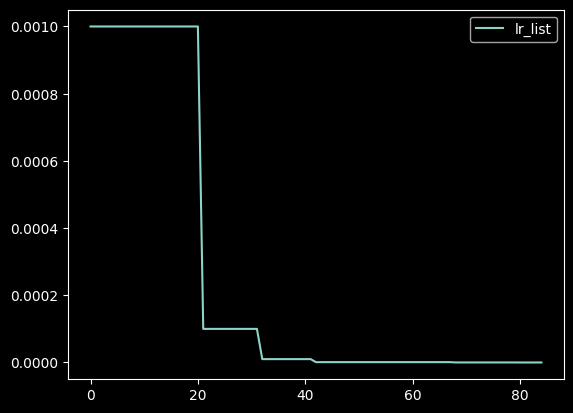

In [187]:
plt.plot(lr_list)
plt.legend(['lr_list'])
plt.show()

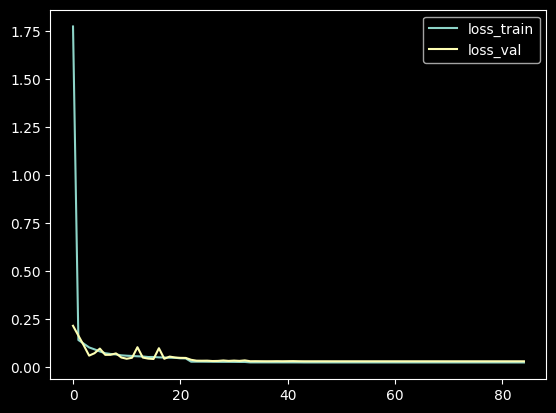

In [184]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

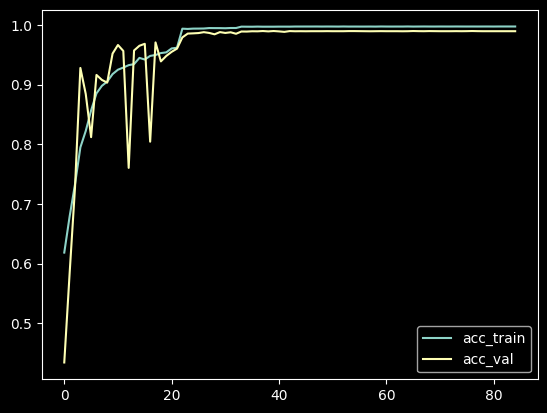

In [183]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

#### Проверка модели регрессии на тестовой выборке

In [190]:
# создаем новую модель
new_reg_model = MyModel(64*64, 2).to(device)

In [191]:
# подгружаем состояние уже обученной
checkpoint = torch.load('model_reg_state_dict_epoch_79.pt')
new_reg_model.load_state_dict(checkpoint['state_model'])

/tmp/ipykernel_6708/4166550582.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_reg_state_dict_epoch_79.pt')


<All keys matched successfully>

In [193]:
new_reg_model.eval()
with torch.no_grad():
    running_test_loss = []
    true_answer = 0
    for x, targets in test_loader:
        # - Данные
        # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # - Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        running_test_loss.append(loss.item())
        mean_test_loss = sum(running_test_loss)/len(running_test_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

    # 2. Расчет значения метрики
    running_test_acc = true_answer / len(test_set)


    print(f"test_loss={mean_test_loss:.4f}, test_acc={running_test_acc:.4f}")

test_loss=0.0291, test_acc=0.9912


Модель показывает потрясающие результаты на тестовой выборке. Это не удивительно, т.к. данные синтетические и очень похожи.

В коде ниже визуализируем то, как модель ошибалась.

Pred coord:tensor([33.2564, 34.2597])
Pred round-coord: tensor([33., 34.])
True coord: tensor([33., 34.])


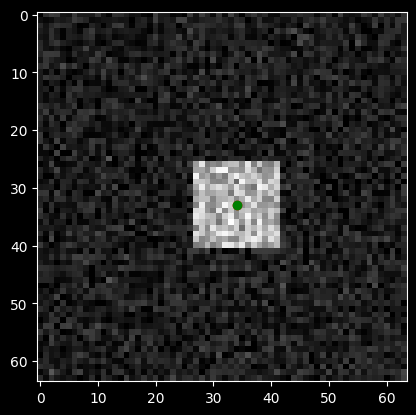

In [198]:
img, coord = test_set[100]

new_reg_model.eval()

pred = new_reg_model(img.view(1, 64*64).to(device)).detach().cpu()

x_pred = torch.round(pred[0])[1].item()
y_pred = torch.round(pred[0])[0].item()

print(f'Pred coord:{pred[0]}')
print(f'\033[31mPred round-coord:\033[0m {torch.round(pred[0])}')
print(f'\033[32mTrue coord:\033[0m {torch.round(pred[0])}')

plt.imshow(img[0].numpy(), cmap = 'gray')
plt.plot(x_pred, y_pred, marker='o', color='red')
plt.plot(coord[1].item(), coord[0].item(), marker='o', color='green')
plt.show()

In [199]:
new_reg_model.eval()
test_loader = DataLoader(test_set, batch_size=len(test_set))

x, targets = next(iter(test_loader))

print(x.shape)
print(targets.shape)

torch.Size([20000, 1, 64, 64])
torch.Size([20000, 2])


In [200]:
pred = new_reg_model(x.reshape(-1, 64*64).to(device)).detach().cpu()

index = ~(torch.round(pred) == targets).all(dim=1)
print(f'Из {len(test_set)} \033[31mНЕправильно\033[0m предсказано {index.sum()}.', end='\n\n')

imgs_false_pred = x[index]
false_pred = pred[index]
rel_false_pred = targets[index]

Из 20000 НЕправильно предсказано 177.



Pred coord:tensor([42.4866, 34.8301])
Pred round-coord: tensor([42., 35.])
True coord: tensor([43., 35.])


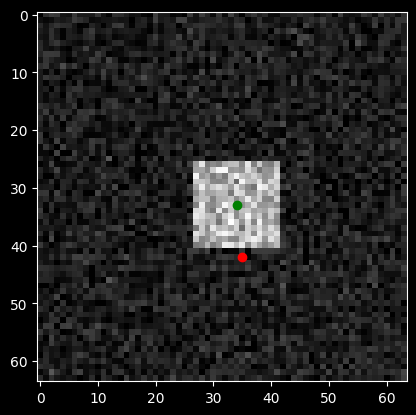

In [203]:
index_false_pred = 125
false_coords = false_pred[index_false_pred]
rel_coords = rel_false_pred[index_false_pred]


print(f'Pred coord:{false_coords}')
print(f'\033[31mPred round-coord:\033[0m {torch.round(false_coords)}')
print(f'\033[32mTrue coord:\033[0m {rel_coords}')

x_pred = torch.round(false_coords)[1].item()
y_pred = torch.round(false_coords)[0].item()


plt.imshow(img[0].numpy(), cmap = 'gray')
plt.plot(x_pred, y_pred, marker='o', color='red')
plt.plot(coord[1].item(), coord[0].item(), marker='o', color='green')
plt.show()